### Neural Networks Project : Gesture Recognition

#### Developed by:
##### 1. Ranveer Singh
##### 2. Anindita Das
##### Dec 2022 

#### Problem Statement
Develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote

In [16]:
# Importing libraries
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import cv2
from matplotlib.pyplot import imread
import abc
from sys import getsizeof

In [17]:
# Setting a random seed
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
from tensorflow import optimizers
tf.random.set_seed(30)

In [18]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [14]:
# importing libraries needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Dropout

In [15]:
# Project Data Path : Change in if required
project_folder='../input/gesturerecognition/Project_data/'

In [9]:
# Define a function to plot training/validation and accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
# Generator : To preprocess the images

class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

        
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
              
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 

                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [20]:
# Sample Model : Using different functionalities from Keras
class ModelConv3D0(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d0=ModelConv3D0()
conv_3d0.initialize_path(project_folder)
conv_3d0.initialize_image_properties(image_height=160,image_width=160)
conv_3d0.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d0_model=conv_3d0.define_model()
conv_3d0_model.summary()

2022-11-23 22:39:01.825955: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

In [22]:
conv_3d0=ModelConv3D0()
conv_3d0.initialize_path(project_folder)
conv_3d0.initialize_image_properties(image_height=160,image_width=160)
conv_3d0.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d0_model=conv_3d0.define_model()
print("Total Parameters:", conv_3d0_model.count_params())
conv_3d0.train_model(conv_3d0_model)

Total Parameters: 1736389


2022-11-23 22:39:10.654695: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
45/45 [==============================] - 277s 6s/step - loss: 1.6372 - categorical_accuracy: 0.3922 - val_loss: 4.7363 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 4.73632, saving model to model_init_2022-11-2322_39_06.328473/model-00001-1.63722-0.39216-4.73632-0.16000.h5
Epoch 2/2
45/45 [==============================] - 242s 5s/step - loss: 1.3605 - categorical_accuracy: 0.4902 - val_loss: 13.8355 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 4.73632


- Above experiments ikmage resolution and number of frames in sequence have more impact on training time than batch_size
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance


### Model-1
#### Batch Size = 20 and No. of Epochs = 25

In [27]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d1_model=conv_3d1.define_model(dense_neurons=256,dropout=0.5)
conv_3d1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 80, 80, 32)   

In [30]:
print("Total Parameters:", conv_3d1_model.count_params())
history_model1=conv_3d1.train_model(conv_3d1_model,augment_data=True)

Total Parameters: 3638981
Epoch 1/25
34/34 [==============================] - 345s 10s/step - loss: 1.9326 - categorical_accuracy: 0.3914 - val_loss: 6.6209 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 6.62095, saving model to model_init_2022-11-2323_03_05.166169/model-00001-1.93262-0.39140-6.62095-0.21000.h5
Epoch 2/25
34/34 [==============================] - 346s 10s/step - loss: 1.5065 - categorical_accuracy: 0.4766 - val_loss: 13.1674 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss did not improve from 6.62095
Epoch 3/25
34/34 [==============================] - 351s 10s/step - loss: 1.2080 - categorical_accuracy: 0.5649 - val_loss: 13.0584 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 6.62095
Epoch 4/25
34/34 [==============================] - 357s 10s/step - loss: 1.1263 - categorical_accuracy: 0.5852 - val_loss: 8.3368 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 6.62095

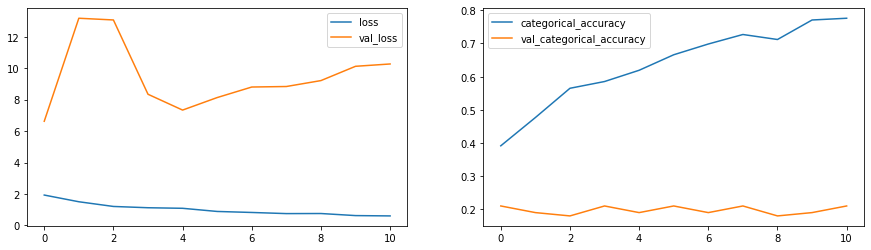

In [31]:
plot(history_model1)

##### We can see  val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 15/25!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

### Model-2
#### Batch Size = 30 and No. of Epochs = 25, Reduce filter size to (2,2,2) and image res to 120 x  120

In [32]:
class ModelConv3D2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d2=ModelConv3D2()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=120,image_width=120)
conv_3d2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 60, 60, 32)    

In [34]:
print("Total Parameters:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Parameters: 1762613
Epoch 1/25
23/23 [==============================] - 157s 7s/step - loss: 2.1059 - categorical_accuracy: 0.3318 - val_loss: 1.7915 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.79150, saving model to model_init_2022-11-2400_06_43.209627/model-00001-2.10586-0.33183-1.79150-0.16000.h5
Epoch 2/25
23/23 [==============================] - 149s 7s/step - loss: 1.5462 - categorical_accuracy: 0.5000 - val_loss: 2.1831 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 1.79150
Epoch 3/25
23/23 [==============================] - 147s 6s/step - loss: 1.3681 - categorical_accuracy: 0.5302 - val_loss: 2.5643 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.79150
Epoch 4/25
23/23 [==============================] - 146s 6s/step - loss: 1.2461 - categorical_accuracy: 0.5701 - val_loss: 2.8676 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 1.79150
Epoch

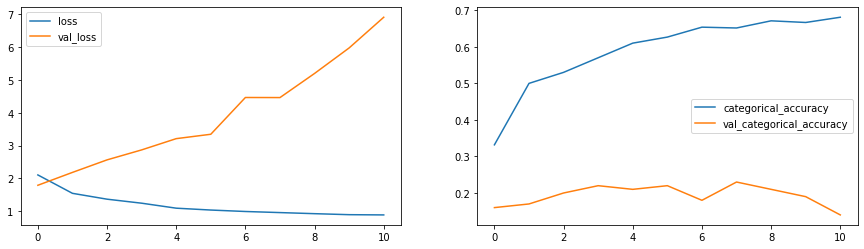

In [35]:
plot(history_model2)

##### Model has a  best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

### Model-3 - Reducing the number of parameters again

In [36]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [37]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(dense_neurons=64,dropout=0.25)
conv_3d3_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 60, 60, 32)    

In [38]:
print("Total Parameters:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Parameters: 504709
Epoch 1/25
34/34 [==============================] - 178s 5s/step - loss: 1.9152 - categorical_accuracy: 0.2949 - val_loss: 1.9387 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.93866, saving model to model_init_2022-11-2400_34_12.119824/model-00001-1.91525-0.29487-1.93866-0.16000.h5
Epoch 2/25
34/34 [==============================] - 176s 5s/step - loss: 1.4649 - categorical_accuracy: 0.4314 - val_loss: 3.0134 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 1.93866
Epoch 3/25
34/34 [==============================] - 174s 5s/step - loss: 1.2384 - categorical_accuracy: 0.5106 - val_loss: 4.3053 - val_categorical_accuracy: 0.1600

Epoch 00003: val_loss did not improve from 1.93866
Epoch 4/25
34/34 [==============================] - 173s 5s/step - loss: 1.1196 - categorical_accuracy: 0.5807 - val_loss: 5.8662 - val_categorical_accuracy: 0.1900

Epoch 00004: val_loss did not improve from 1.93866
Epoch 

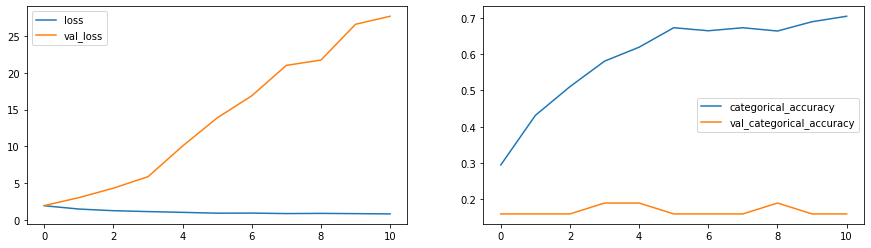

In [39]:
plot(history_model3)

###### For the above low memory foot print model the best validation accuracy of 73%

### Model-4 
#### CNN-LSTM Model

In [12]:
class RNNCNN4(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
rnn_cnn4=RNNCNN4()
rnn_cnn4.initialize_path(project_folder)
rnn_cnn4.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn4.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn4_model=rnn_cnn4.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn4_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    1

In [15]:
print("Total Parameters:", rnn_cnn4_model.count_params())
history_model4=rnn_cnn4.train_model(rnn_cnn4_model,augment_data=True)

Total Parameters: 1657445


2022-11-24 08:12:14.545823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
34/34 [==============================] - 259s 7s/step - loss: 1.4856 - categorical_accuracy: 0.3462 - val_loss: 1.6844 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.68438, saving model to model_init_2022-11-2408_12_09.871247/model-00001-1.48563-0.34615-1.68438-0.21000.h5
Epoch 2/20
34/34 [==============================] - 210s 6s/step - loss: 1.2233 - categorical_accuracy: 0.4925 - val_loss: 1.8318 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.68438
Epoch 3/20
34/34 [==============================] - 210s 6s/step - loss: 1.1557 - categorical_accuracy: 0.5241 - val_loss: 1.9596 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss did not improve from 1.68438
Epoch 4/20
34/34 [==============================] - 210s 6s/step - loss: 1.0399 - categorical_accuracy: 0.5807 - val_loss: 2.7398 - val_categorical_accuracy: 0.1800

Epoch 00004: val_loss did not improve from 1.68438
Epoch 5/20
34/34 [=============

In [ ]:
plot(history_model4)

##### For CNN - LSTM model we get a best validation accuracy of 85%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

### Lets check the model performance with data augmentation

### Model-5 with Augmentation (Similar to Model-1)
#### (3,3,3) Filter & 160x160 Image resolution 

In [6]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

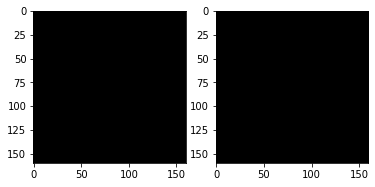

In [10]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

In [23]:
class ModelConv3D5(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=160,image_width=160)
conv_3d5.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d5_model=conv_3d5.define_model(dense_neurons=256,dropout=0.5)
conv_3d5_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 80, 80, 32)   

In [25]:
print("Total Parameters:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Parameters: 3638981
Epoch 1/20
34/34 [==============================] - 399s 12s/step - loss: 2.0004 - categorical_accuracy: 0.3635 - val_loss: 2.5484 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-11-2409_07_49.992537/model-00001-2.00039-0.36350-2.54840-0.16000.h5
Epoch 2/20
34/34 [==============================] - 380s 11s/step - loss: 1.4624 - categorical_accuracy: 0.4849 - val_loss: 4.9089 - val_categorical_accuracy: 0.1400

Epoch 00002: saving model to model_init_2022-11-2409_07_49.992537/model-00002-1.46236-0.48492-4.90889-0.14000.h5
Epoch 3/20
34/34 [==============================] - 391s 12s/step - loss: 1.3257 - categorical_accuracy: 0.5407 - val_loss: 8.8879 - val_categorical_accuracy: 0.1400

Epoch 00003: saving model to model_init_2022-11-2409_07_49.992537/model-00003-1.32574-0.54072-8.88788-0.14000.h5
Epoch 4/20
34/34 [==============================] - 398s 12s/step - loss: 1.1898 - categorical_accuracy: 0.5777 - val_loss: 10.9473 - 

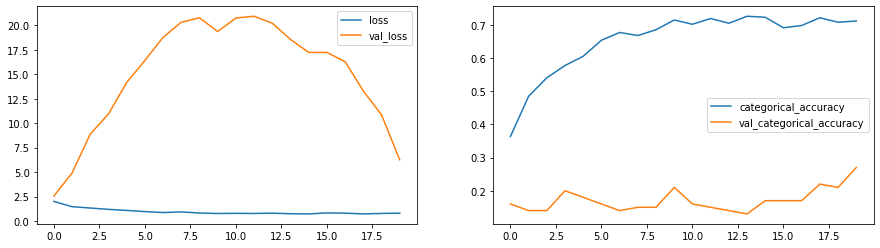

In [26]:
plot(history_model5)

### Model-6 with Augmentation (Similar to Model-2)
#### (2,2,2) Filter  & 120x120 Image resolution

In [17]:
class ModelConv3D6(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d6_model=conv_3d6.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d6_model.summary()

2022-11-24 13:23:05.374026: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [19]:
print("Total Parameters:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Parameters: 1762613


2022-11-24 13:23:12.606363: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
23/23 [==============================] - 207s 9s/step - loss: 2.1476 - categorical_accuracy: 0.3167 - val_loss: 1.8825 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-11-2413_23_06.076234/model-00001-2.14764-0.31674-1.88254-0.16000.h5
Epoch 2/25
23/23 [==============================] - 154s 7s/step - loss: 1.6031 - categorical_accuracy: 0.4510 - val_loss: 2.2610 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2022-11-2413_23_06.076234/model-00002-1.60313-0.45098-2.26102-0.23000.h5
Epoch 3/25
23/23 [==============================] - 168s 7s/step - loss: 1.3470 - categorical_accuracy: 0.5468 - val_loss: 2.9486 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2022-11-2413_23_06.076234/model-00003-1.34701-0.54676-2.94856-0.20000.h5
Epoch 4/25
23/23 [==============================] - 160s 7s/step - loss: 1.2815 - categorical_accuracy: 0.5475 - val_loss: 3.0152 - val_categorical_accuracy: 0.220

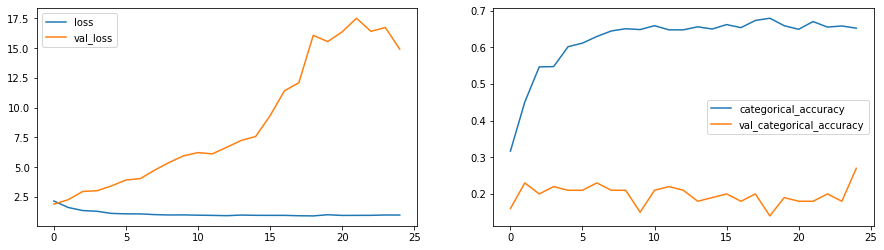

In [20]:
plot(history_model6)

### Model-7 with Augmentation (Similar to Model3)

In [35]:
class ModelConv3D7(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 60, 60, 32)    

In [37]:
print("Total Parameters:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Parameters: 504709
Epoch 1/25
34/34 [==============================] - 219s 6s/step - loss: 1.8708 - categorical_accuracy: 0.3198 - val_loss: 1.6972 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-11-2419_03_23.544196/model-00001-1.87085-0.31976-1.69717-0.21000.h5
Epoch 2/25
34/34 [==============================] - 202s 6s/step - loss: 1.2827 - categorical_accuracy: 0.5098 - val_loss: 2.0888 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2022-11-2419_03_23.544196/model-00002-1.28267-0.50980-2.08883-0.18000.h5
Epoch 3/25
34/34 [==============================] - 200s 6s/step - loss: 1.1298 - categorical_accuracy: 0.5566 - val_loss: 2.1631 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to model_init_2022-11-2419_03_23.544196/model-00003-1.12983-0.55656-2.16312-0.18000.h5
Epoch 4/25
34/34 [==============================] - 201s 6s/step - loss: 0.9775 - categorical_accuracy: 0.6252 - val_loss: 2.5283 - val_ca

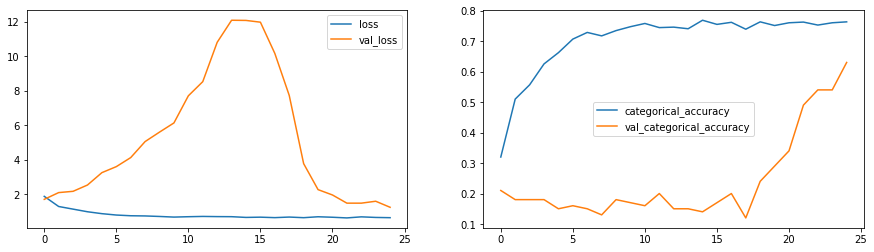

In [38]:
plot(history_model7)

### Model-8 with Augmentation (Similar to Model-4)
#### CNN LSTM with GRU

In [12]:
class RNNCNN8(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn8=RNNCNN8()
rnn_cnn8.initialize_path(project_folder)
rnn_cnn8.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn8.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn8_model=rnn_cnn8.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn8_model.summary()

2022-11-24 17:19:41.362330: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    1

In [20]:
print("Total Parameters:", rnn_cnn8_model.count_params())
history_model8=rnn_cnn8.train_model(rnn_cnn8_model,augment_data=True)

Total Parameters: 2573925


2022-11-24 17:19:50.950135: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
34/34 [==============================] - 255s 7s/step - loss: 1.4192 - categorical_accuracy: 0.3989 - val_loss: 1.7141 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2022-11-2417_19_46.254720/model-00001-1.41925-0.39894-1.71409-0.16000.h5
Epoch 2/20
34/34 [==============================] - 199s 6s/step - loss: 1.0524 - categorical_accuracy: 0.5618 - val_loss: 1.8838 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2022-11-2417_19_46.254720/model-00002-1.05245-0.56184-1.88379-0.20000.h5
Epoch 3/20
34/34 [==============================] - 201s 6s/step - loss: 0.8367 - categorical_accuracy: 0.6817 - val_loss: 2.1680 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2022-11-2417_19_46.254720/model-00003-0.83668-0.68175-2.16797-0.15000.h5
Epoch 4/20
34/34 [==============================] - 204s 6s/step - loss: 0.6959 - categorical_accuracy: 0.7293 - val_loss: 2.0158 - val_categorical_accuracy: 0.220

### Awesome results! 98% Training accuracy and 93% validation accuracy :)

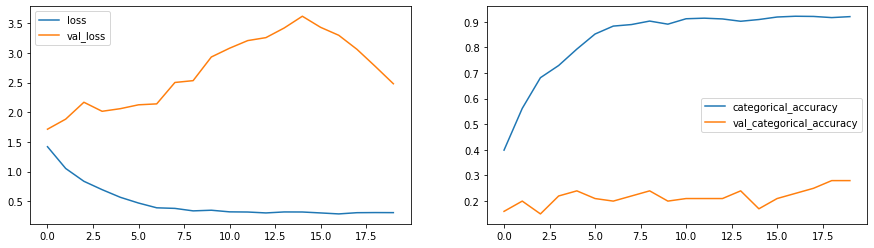

In [21]:
plot(history_model8)

# \## Final Models

## after all model 6 perfomed best amost all

- Training Accuracy : 96%, Validation Accuracy : 92% from model 6 with total parameters : 1762613


- The best model is model_init_2022-11-2413_23_06.076234/model-00025-0.96789-0.65234-14.92046-0.27000.h5

### Model Loading and Testing

In [47]:
import time
from keras.models import load_model
model = load_model('model_init_2022-11-2413_23_06.076234/model-00025-0.96789-0.65234-14.92046-0.27000.h5')

In [48]:
test_generator=RNNCNN8()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [49]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [50]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3]


### Performance could be improve using CNN with LSTM 